In [1]:
import torch
import torch.nn as nn
from transformers import DistilBertModel, DistilBertTokenizer
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Path to the model results and test data
model_path = "/content/drive/MyDrive/645/ENEL 645 Group Work/Assignment 2/best_fusion_model.pth"
test_dir = "/content/drive/MyDrive/645/ENEL 645 Group Work/Assignment 2/Test"

# Verify that files exist
print(f"Checking if model exists at: {model_path}")
if os.path.exists(model_path):
    print("Model file found.")
else:
    print("Model file not found. Please update the path.")

print(f"\nChecking if test directory exists at: {test_dir}")
if os.path.exists(test_dir):
    print(f"Test directory found. Contains {len(os.listdir(test_dir))} items")
    print("Classes found:")
    for item in os.listdir(test_dir):
        if os.path.isdir(os.path.join(test_dir, item)):
            print(f" - {item}: {len(os.listdir(os.path.join(test_dir, item)))} images")
else:
    print("Test directory not found. Please update the path.")

Checking if model exists at: /content/drive/MyDrive/645/ENEL 645 Group Work/Assignment 2/best_fusion_model.pth
Model file found.

Checking if test directory exists at: /content/drive/MyDrive/645/ENEL 645 Group Work/Assignment 2/Test
Test directory found. Contains 4 items
Classes found:
 - Black: 695 images
 - Blue: 1086 images
 - Green: 799 images
 - TTR: 852 images


In [4]:
class GarbageClassifierFusion(nn.Module):
    """
    A multimodal neural network that fuses image and text features for garbage classification.
    Uses EfficientNet-B0 for image processing and DistilBERT for text processing.
    """
    def __init__(self, num_classes=4):
        super(GarbageClassifierFusion, self).__init__()

        # Image encoder (EfficientNet)
        self.image_encoder = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.image_features = nn.Sequential(*list(self.image_encoder.children())[:-2])
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        img_embedding_dim = 1280  # EfficientNet-B0's feature dimension

        # Text encoder (DistilBERT)
        self.text_encoder = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.text_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        text_embedding_dim = 768  # DistilBERT's hidden size

        # Image projection layer
        self.image_projector = nn.Sequential(
            nn.Linear(img_embedding_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Text projection layer
        self.text_projector = nn.Sequential(
            nn.Linear(text_embedding_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        fusion_dim = 512 + 512
        # Fusion layers
        self.fusion_layers = nn.Sequential(
            nn.Linear(fusion_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, images, text_inputs):
        # Process images
        img_features = self.image_features(images)
        img_features = self.avg_pool(img_features)
        img_features = torch.flatten(img_features, 1)
        img_embeddings = self.image_projector(img_features)

        # Process text
        text_outputs = self.text_encoder(**text_inputs).last_hidden_state
        text_embeddings = torch.mean(text_outputs, dim=1)
        text_embeddings = self.text_projector(text_embeddings)

        # Concatenate for fusion
        fused_features = torch.cat([img_embeddings, text_embeddings], dim=1)
        output = self.fusion_layers(fused_features)
        return output

class MultimodalGarbageDataset(torch.utils.data.Dataset):
    """
    Custom dataset class for handling multimodal (image + text) garbage classification data.
    """
    def __init__(self, image_dataset, tokenizer, max_length=32):
        self.image_dataset = image_dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.image_dataset)

    def __getitem__(self, idx):
        # Get image and label
        image, label = self.image_dataset[idx]

        # Extract text description from filename
        file_path = self.image_dataset.samples[idx][0]
        description = self._get_description_from_filename(file_path)

        # Tokenize the text description
        text_encoding = self.tokenizer(
            description,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'image': image,
            'text_inputs': {
                'input_ids': text_encoding['input_ids'].squeeze(0),
                'attention_mask': text_encoding['attention_mask'].squeeze(0)
            },
            'label': label,
            'file_path': file_path  # Include file path for analysis
        }

    def _get_description_from_filename(self, file_path):
        filename = file_path.split('/')[-1].split('.')[0]
        description = '_'.join(filename.split('_')[:-1])
        description = description.replace('_', ' ')
        return description.lower()

In [6]:
# Standard evaluation transform
evaluation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create test dataset
test_dataset = datasets.ImageFolder(test_dir, transform=evaluation_transform)

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create multimodal test dataset
multimodal_test_dataset = MultimodalGarbageDataset(test_dataset, tokenizer)

# Create test dataloader
batch_size = 16
test_loader = DataLoader(multimodal_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Get class names
class_names = test_dataset.classes
print(f"Classes: {class_names}")

# Initialize model
model = GarbageClassifierFusion(num_classes=len(class_names))
model = model.to(device)

Classes: ['Black', 'Blue', 'Green', 'TTR']


In [7]:
# Load the trained weights
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.eval()
print(f"Successfully loaded model from {model_path}")

Successfully loaded model from /content/drive/MyDrive/645/ENEL 645 Group Work/Assignment 2/best_fusion_model.pth


In [8]:
# Evaluate the model and compute detailed metrics
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_file_paths = []
    all_probs = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            text_inputs = {
                'input_ids': batch['text_inputs']['input_ids'].to(device),
                'attention_mask': batch['text_inputs']['attention_mask'].to(device)
            }
            labels = batch['label'].to(device)
            file_paths = batch['file_path']

            # Get model predictions
            outputs = model(images, text_inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            # Store results
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_file_paths.extend(file_paths)
            # Convert to numpy before adding to list
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    cm = confusion_matrix(all_labels, all_preds)

    # Calculate per-class metrics
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

    # Calculate overall F1 score (weighted)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    # Create DataFrame for class metrics
    class_metrics = {}
    for class_name in class_names:
        if class_name in report:
            class_metrics[class_name] = {
                'precision': report[class_name]['precision'],
                'recall': report[class_name]['recall'],
                'f1-score': report[class_name]['f1-score'],
                'support': report[class_name]['support']
            }

    metrics_df = pd.DataFrame(class_metrics).transpose()

    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report,
        'metrics_df': metrics_df,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'predictions': all_preds,
        'labels': all_labels,
        'file_paths': all_file_paths,
        'probabilities': np.array(all_probs)
    }

print("Evaluating model")
results = evaluate_model(model, test_loader, class_names)

# Print overall metrics
print(f"\nModel Performance Metrics:")
print(f"Accuracy: {results['accuracy']:.4f}")
print(f"F1 Score (weighted): {results['f1_score']:.4f}")
print(f"Precision (weighted): {results['precision']:.4f}")
print(f"Recall (weighted): {results['recall']:.4f}")


Evaluating model

Model Performance Metrics:
Accuracy: 0.8319
F1 Score (weighted): 0.8283
Precision (weighted): 0.8346
Recall (weighted): 0.8319


In [10]:
# Display detailed classification report
print("\nDetailed Classification Report:")
pd.DataFrame(results['metrics_df'])


Detailed Classification Report:


,precision,recall,f1-score,support
Black,0.792135,0.608633,0.688365,695.0
Blue,0.771057,0.927256,0.841973,1086.0
Green,0.921816,0.914894,0.918342,799.0
TTR,0.868586,0.814554,0.840703,852.0


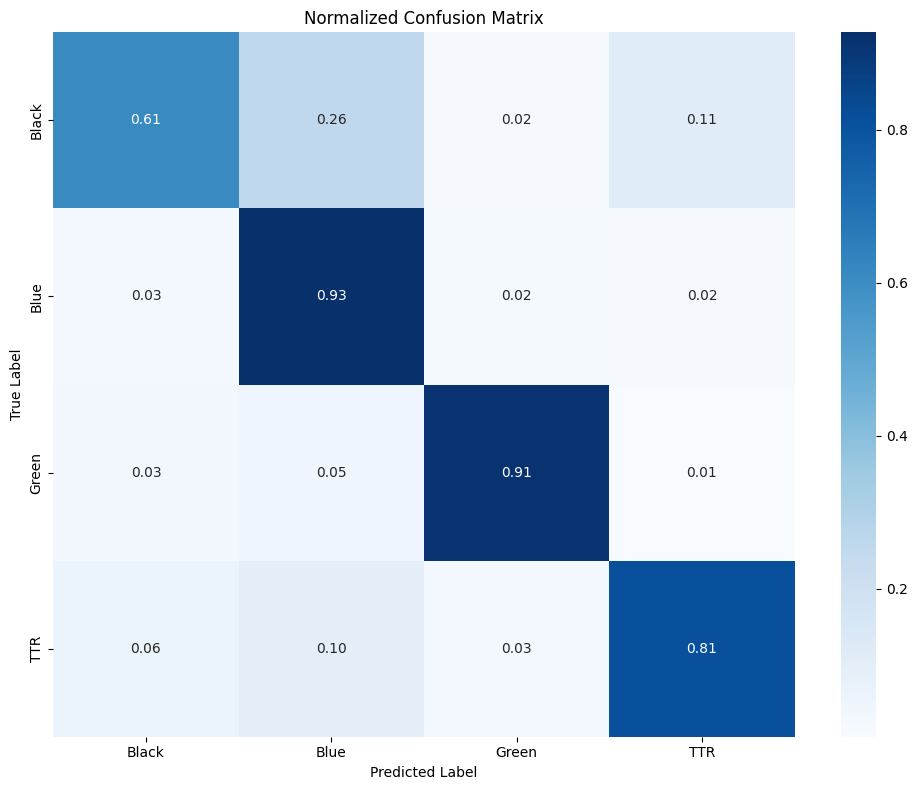

In [11]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = results['confusion_matrix']
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

In [26]:
# Analyze misclassifications
predictions = np.array(results['predictions'])
labels = np.array(results['labels'])
file_paths = np.array(results['file_paths'])
probs = results['probabilities']

# Find misclassified examples
misclassified_idx = np.where(predictions != labels)[0]

if len(misclassified_idx) == 0:
    print("No misclassifications found!")

# Create a DataFrame for misclassified examples
misclassified_data = []
for idx in misclassified_idx:
    true_class = class_names[labels[idx]]
    pred_class = class_names[predictions[idx]]
    confidence = probs[idx][predictions[idx]]
    file_name = os.path.basename(file_paths[idx])

    misclassified_data.append({
        'File': file_name,
        'True Class': true_class,
        'Predicted Class': pred_class,
        'Confidence': confidence,
        'Path': file_paths[idx]
    })

misclassified_df = pd.DataFrame(misclassified_data)

# Sort by confidence to find the most confidently wrong predictions
misclassified_df = misclassified_df.sort_values('Confidence', ascending=False)

# Count misclassifications by class pairs
misclass_counts = misclassified_df.groupby(['True Class', 'Predicted Class']).size().reset_index(name='Count')
misclass_counts = misclass_counts.sort_values('Count', ascending=False)

print("Misclassification Pairs:")
display(misclass_counts.head(12))

Misclassification Pairs:


,True Class,Predicted Class,Count
0,Black,Blue,179
10,TTR,Blue,83
2,Black,TTR,79
9,TTR,Black,52
7,Green,Blue,37
3,Blue,Black,33
6,Green,Black,26
4,Blue,Green,25
11,TTR,Green,23
5,Blue,TTR,21
